### Code for generating an acquisition series that sets the autofocus (AF) device ON between z-stacks

It is important to first set up the micromanager config properly! Although the only real important part for this code is knowing what channel group you have and what your channels are

see more: https://pycro-manager.readthedocs.io/en/latest/user_guide.html 

In [32]:
from pycromanager import Acquisition, Core, JavaObject
import numpy as np

core = Core()
print(core) # this just makes sure you're connected to micromanager

In [40]:
afd = core.get_auto_focus_device()
afm = core.get_auto_focus_offset()

In [41]:
print(afm)

4.4e-323


In [42]:
core.enable_continuous_focus(False)
print(core.is_continuous_focus_enabled())

False


### Load position list from file
Save position list from uManager and load into pycromanager (set 'fp')

In [33]:
fp = 'C:\\Users\\ar138\\Desktop\\Research\\Codes\\pycromanage\\test_pos.pos'

positionList = JavaObject('org.micromanager.PositionList')

positionList.load(fp)
nb_positions = positionList.get_number_of_positions()
position_list = []
for i in range(nb_positions):
    position = positionList.get_position(i)
    x = position.get_x()
    y = position.get_y()
    z = position.get_z()
    pos = [x, y, z]
    position_list.append(pos)
display(position_list)

[[1.5, 1.5, 2],
 [1.5, -49.695, 4],
 [-49.695, 1.5, 4],
 [-49.695, 103.89, 4],
 [-152.085, 103.89, 11]]

### Set acquisition settings
Define the parameters for the imaging session

In [34]:

num_f = 10        # number of frames per 'burst'
exp1 = 20         # exposure time (ms) of the z-stack frames
exp2 = 20         # exposure time (ms) of the burst frames
sub_interval = 10 # interval between subsets (sec)
num_subs = 3     # number of times to repeat
z_hrange = 2.5    # +/- in um from relative z
z_interval = 0.5  # z-stack step size (um)

chgroup = 'Channel' # Name of the channel group in MicroManager
ch1 = 'FITC'        # Channel for the z-stack
ch2 = 'DAPI'        # Channel for the burst

In [88]:
np.arange(start=-z_hrange, stop=z_hrange, step=z_interval)

array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

### Generate the event series
Loops over subsets, positions to generate burst & z-stack at each

Creates a list 'events' to give to the acquisition manager

In [31]:
def post_hook_fn(event):
    #print(len(event))
    if (len(event)) != 10:
        axs = event['axes']
        if (axs['channel'] == 'FITC') and (axs['z'] == 10 ) and (axs['p'] == 4 ):
            core.enable_continuous_focus(True)
            print('AF turned on')
    
    return event

In [35]:
def pre_hook_fn(event):
    if core.is_continuous_focus_enabled():
        core.enable_continuous_focus(False)
    return event

In [36]:

events = []
for sub in range(num_subs):
    
    for pos_ind, [x,y,z] in enumerate(position_list):
        
        for frame in range(num_f):
            
            evt = {
                    'axes': {'subset': sub, 'time': frame, 'channel': ch2, 'z':5, 'p':pos_ind}, 
                    'config_group': [chgroup, ch2], 
                    'min_start_time' : sub * sub_interval,
                    'exposure': exp2,
                    'z' : z,
                    'x':x,
                    'y':x,
            }
            
            events.append(evt)
        
        for z_ind,z_pos in enumerate(np.arange(start=-z_hrange, stop=z_hrange+z_interval, step=z_interval)):
            
            evt = {
                    'axes': {'subset': sub, 'time': num_f, 'channel': ch1, 'z':z_ind, 'p':pos_ind}, 
                    'config_group': [chgroup, ch1], 
                    'min_start_time' : sub * sub_interval,
                    'exposure': exp1,
                    'z': z+z_pos,
                    'x':x,
                    'y':x,
            }
            events.append(evt)

            
print('First event: ', events[0])   # take a look at your first & last event
print('Last event: ',events[-1])

First event:  {'axes': {'subset': 0, 'time': 0, 'channel': 'DAPI', 'z': 5, 'p': 0}, 'config_group': ['Channel', 'DAPI'], 'min_start_time': 0, 'exposure': 20, 'z': 2, 'x': 1.5, 'y': 1.5}
Last event:  {'axes': {'subset': 2, 'time': 10, 'channel': 'FITC', 'z': 10, 'p': 4}, 'config_group': ['Channel', 'FITC'], 'min_start_time': 20, 'exposure': 20, 'z': 13.5, 'x': -152.085, 'y': -152.085}


In [51]:
event = events[0]
event['axes']['subset']

0

### Acquire

In [37]:
# Take the acquisition

with Acquisition(directory='Downloads', name='test_aq_AF_dataset2',post_hardware_hook_fn=post_hook_fn, pre_hardware_hook_fn = pre_hook_fn) as acq:
    
    acq.acquire(events)

    dataset = acq.get_dataset()

AF turned on
AF turned on
AF turned on


In [38]:
from pycromanager import Dataset

#This path is to the top level of the dataset
data_path = 'Downloads/test_aq_AF_dataset2_1'

dataset = Dataset(data_path)

Dataset opened                 


In [39]:
dataset.axes

{'time': SortedSet([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
 'channel': SortedSet(['DAPI', 'FITC']),
 'subset': SortedSet([0, 1, 2]),
 'p': SortedSet([0, 1, 2, 3, 4]),
 'z': SortedSet([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])}

In [112]:
img = dataset.read_image(channel = 'DAPI', z = 5, time = 0, p = 0, subset = 0)
img.shape

(512, 512)

In [41]:
dask_array = dataset.as_array()
print(dask_array.shape)
print('(time, channel, subset, pos, z, x, y)')

(11, 2, 3, 5, 11, 512, 512)
(time, channel, subset, pos, z, x, y)


In [44]:
DAPI1 = dask_array[0:9,0,:,0,5]
DAPI1.shape

(9, 3, 512, 512)

In [42]:
FITC1 = dask_array[10,1,:,0,:]
FITC1.shape

(3, 11, 512, 512)

In [45]:
import tifffile
tifffile.imwrite('DAPI_p1.tiff', DAPI1, imagej=True, metadata={'axes': 'TZYX'})

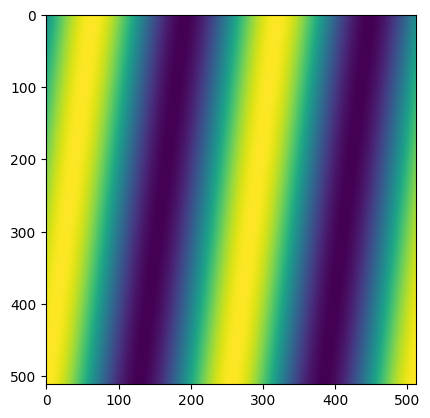

In [28]:
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
plt.imshow(FITC1)